In [197]:
def whl_to_pos(f, fill_gaps):
    if type(f) == type('s'):
        f = open(f)

    pos = []
    for line in f:
        fs = [float(n) for n in line.split(' ') if len(n) > 0]
        if fs[0] < 1000 and fs[2] < 1000:
            pos.append([(fs[0]+fs[2])/2, (fs[1]+fs[3])/2])
        else:
            if fs[0] < 1000:
                pos.append([fs[0], fs[1]])
            else:
                if fs[2] < 1000:
                    pos.append([fs[2], fs[3]])
                else:
                    pos.append([0, 0])

    # filling gaps with previous value - this will not add high-speed entires but will allow for seamless display and easier speed estimation
    if fill_gaps:
        for i in range(1, len(pos)):
            if pos[i][0] == 0:
                pos[i]=pos[i-1][:]

    return pos

def smooth_whl(whl):
    whls = []
    rad = 5
    for i in range(rad):
        whls.append(whl[i])

    for i in range(rad, len(whl) - rad):
        # don't smooth if from different environments
        e1 = False
        e2 = False
        EBORD = 200
        for j in range(-rad, rad+1):
            if whl[i+j][0] > 0.1 and whl[i+j][0] < EBORD:
                e1 = True
            if whl[i+j][0] > 0.1 and whl[i+j][0] > EBORD:
                e2 = True
        if e1 and e2:
            whls.append(whl[i])
            continue

        x = sum([p[0] for p in whl[i-rad:i+rad+1]])
        y = sum([p[1] for p in whl[i-rad:i+rad+1]])
        whls.append([x / float(2 * rad + 1), y / float(2 * rad + 1)])

    for i in range(len(whl) - rad, len(whl)):
        whls.append(whl[i])

    return whls
#==========================================================================================
def jitter(maxjit):
    return random.random() * maxjit
#==========================================================================================
def whl_to_speed(whl):
    speed = []
    SRAD = 8
    for i in range(0, SRAD):
        speed.append(0)
    for i in range(SRAD, len(whl)-SRAD):
        speed.append(np.sqrt((whl[i+SRAD][0]-whl[i-SRAD][0])**2 + (whl[i+SRAD][1]-whl[i-SRAD][1])**2))
    for i in range(len(whl)-SRAD, len(whl)):
        speed.append(0)

    # print 'Speed size before smooth: %d' % len(speed)
    # average smoothing
    speed = np.convolve(np.array(speed), np.array([1] * 15) / 15.0, mode='same')
    # print 'Speed size after smooth: %d' % len(speed)

    return speed

In [3]:
class SWR:
    def __init__(self, id, t):
            self.id = id
            self.t = t
            self.seq = []
    def add_pos(self, p):
        self.seq.append(p)
    def len(self):
        return len(self.seq)
    def aseq(self):
        return np.array(self.seq)

In [4]:
from matplotlib import pyplot as plt
from sys import argv
from numpy import mean, std
# from call_log import *
import numpy as np
import os
import random
from IPython import display
import time

In [439]:
animal = 'jc174'
day = '0910'

os.chdir('/hdr/data/processing/%s/%s/' % (animal, day))
whlpath = '22sai/%s_%s_22sai.whl' % (animal, day)

#whlpath = '18a6w/jc174_0907_18a6w.whl'
#whlpath = '16sai/jc174_0909_16sai.whl'
#whlpath = '16sai/jc174_0909_16sai.whl'
#whlpath = '12sai/jc174_0912_12sai.whl'
#whlpath = '22saibin/jc181_1201_22saibin.whl'

swrdecpath = '18a6w/N80_O75_lax356_IGNORELX0_W2400_R50_USEHMM1.swrdec'

#trialspath = '22sai/jc182_0111_22sai.whl.trials'
#trialspath = '22sai/jc182_0116_22sai.whl.trials'

In [440]:
# prepare whl
whl = whl_to_pos(whlpath, True)
whl = smooth_whl(whl)

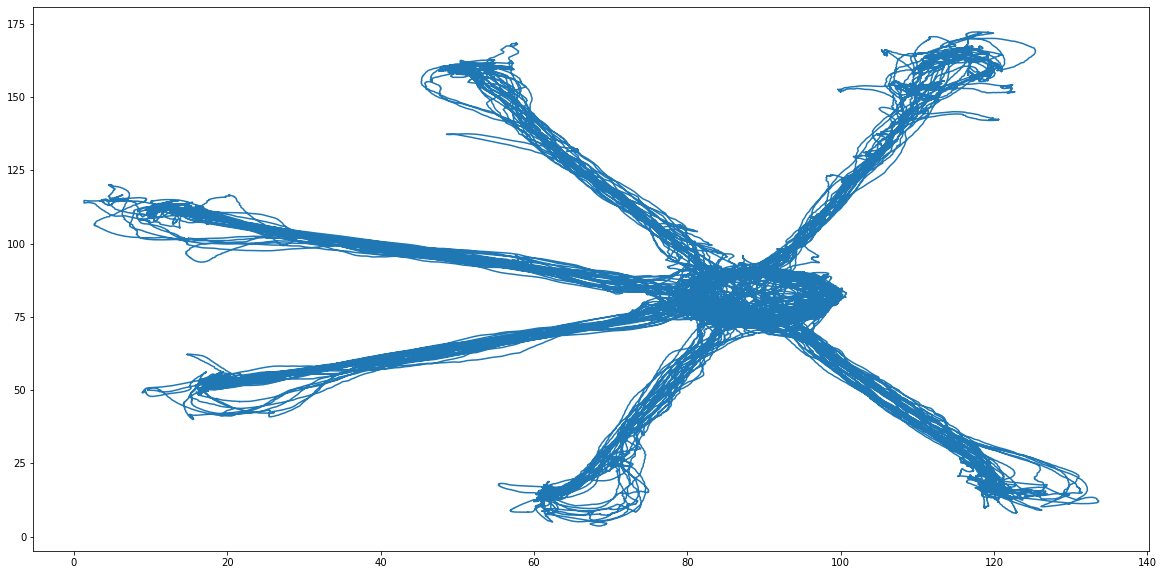

In [441]:
whl = np.array(whl)
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(whl[:,0], whl[:,1])

In [442]:
# read swrdec - plot locations and encoded path
fswrdec = open(swrdecpath)
swrs = []
while True:
    swrhead = fswrdec.readline()
    if len(swrhead) < 1:
        break
        
    ws = swrhead.split(' ')
    swr = SWR(int(ws[0]), int(ws[1]))
    nseq = int(ws[-1])
    for ip in range(nseq):
        ws = fswrdec.readline().split(' ')
        swr.add_pos([int(ws[0]), int(ws[1])])
    swrs.append(swr)

FileNotFoundError: [Errno 2] No such file or directory: '18a6w/N80_O75_lax356_IGNORELX0_W2400_R50_USEHMM1.swrdec'

In [443]:
# load map position -> arm; [x,y]
arm_map = np.loadtxt('sectors.map')

# map time[whl] (-> position) -> arm
tarm = []
BIN = 4
for t in range(len(whl)):
    # 0,1 for all
    tarm.append(arm_map[int(round(whl[t,0]/BIN)), int(round(whl[t,1]/BIN))])
    
# map time (whl index) -> arm order of visit [just go through time->arm and filter by min. visit]
#   starting from 0 (as it is an array index)
# -1 = unknown/center
VISTHOLD = 200
current_ord = 0
curarm = 0
viscount = 0
t = 0
tord = []
while t < len(tarm):
    # till arm change; if > thold - fill with next order, if not - fill with 0
    while t < len(tarm) and tarm[t] == 6:
        t += 1
        tord.append(-1)
    
    tstart = t
    while t < len(tarm) and tarm[t] == tarm[tstart]:
        t += 1
    
    # different sector encountered
    
    if t - tstart >= VISTHOLD:
        fill = current_ord #tarm[tstart]
        current_ord += 1
    else:
        fill = -1
    for tfill in range(tstart, t):
            tord.append(fill)
    tstart = t
       
# invert the array above: order -> arm + no repeats
# order of arm visit
armorder = []
# whl index to order of visit
#whlitoord = []
if tord[0] != -1:
    armorder.append(tord[0])
#    whlitoord.append(0)
#else:
#    whlitoord.append(-1)
for oi in range(1, len(tord)):
    if tord[oi] != tord [oi-1] and tord[oi] != -1:
        armorder.append(tarm[oi])
    #whlitoord.append(len(armorder)-1)
    
print('Validate array lengthes', len(whl), len(tord), len(armorder))
#tord[2000:]
armorder
#whlitoord[100:]

#os.getcwd()
#len(armorder), armorder
#plt.hist(armorder)

Validate array lengthes 60000 60000 83


[5.0,
 4.0,
 2.0,
 1.0,
 3.0,
 0.0,
 3.0,
 5.0,
 0.0,
 4.0,
 1.0,
 5.0,
 2.0,
 0.0,
 3.0,
 1.0,
 4.0,
 5.0,
 2.0,
 3.0,
 5.0,
 1.0,
 4.0,
 0.0,
 3.0,
 2.0,
 0.0,
 3.0,
 1.0,
 4.0,
 0.0,
 3.0,
 2.0,
 0.0,
 3.0,
 2.0,
 5.0,
 1.0,
 4.0,
 1.0,
 3.0,
 5.0,
 2.0,
 4.0,
 0.0,
 3.0,
 4.0,
 2.0,
 5.0,
 3.0,
 0.0,
 3.0,
 1.0,
 4.0,
 0.0,
 2.0,
 3.0,
 5.0,
 1.0,
 4.0,
 0.0,
 3.0,
 2.0,
 3.0,
 5.0,
 1.0,
 4.0,
 0.0,
 3.0,
 4.0,
 1.0,
 5.0,
 2.0,
 3.0,
 0.0,
 4.0,
 1.0,
 3.0,
 5.0,
 0.0,
 4.0,
 5.0,
 2.0]

In [172]:
# which arm is predicted by replay - consider 3 before, current and 3 after
# TODO: consider only within current trial
armpred = [0] * 7

PLOT = False

# iterate through replays and plot encoded trajectory along with recent past adn future positions
RAD = 1350
for si in range(0, len(swrs)):
    swr = swrs[si]
    #plt.figure()
    whlt = int(swr.t/480)
    seq = swr.aseq().astype(float)
    seq += np.random.rand(seq.shape[0], seq.shape[1]) * 0.5
    
    # which arm replayed - div seq by 2 ! - different bin sizes used !
    # OPT: consider more samples if 
    reparm = arm_map[int(swr.seq[0][0]/2), int(swr.seq[0][1]/2)]
    iswr = 0
    while reparm == 6 and iswr < len(swr.seq):
        reparm = arm_map[int(swr.seq[iswr][0]/2), int(swr.seq[iswr][1]/2)]
        iswr += 1
    
    # current arm
    curarm = arm_map[int(whl[whlt,0]/4), int(whl[whlt,1]/4)]
    
    # LIMIT REGION WHERE REPLAY IS CONSIDERED; 6 - center
    if curarm != 6:
        continue
    
    # which arm relative to current
    curord = tord[whlt]
    found = False
    for ashift in [0, -1, 1, -2, 2, -3 ,3]:
        candind = curord + ashift
        if candind < 0 or candind >= len(armorder):
            continue
        if armorder[candind] == reparm:
            armpred[ashift + 3] += 1
            # OPT: continue
            found = True
            break
            
    if not found:
        ashift = None
    
    if PLOT:
        plt.figure()
        plt.xlim([0, 175])
        plt.ylim([0, 165])
        plt.plot(whl[whlt-RAD:whlt,0], whl[whlt-RAD:whlt,1])
        plt.plot(whl[whlt:whlt+RAD,0], whl[whlt:whlt+RAD,1], color='green')
        plt.scatter(whl[whlt,0], whl[whlt,1], s=300, color='black')
        # print(seq)
        plt.plot(seq[:,0]*2, seq[:,1]*2, color='red', linewidth=10)
        plt.title(str(si))
        #input()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(1.5)
                
        print('Arm number:', tarm[whlt])
        print('Arm in the order of visit:', curord)
        print('Replayed arm number:', reparm)
        print('Arm replay relative to current arm order:', ashift)

armpred = np.array(armpred)
armpred = armpred[np.array([5,3,1,0,2,4,6])]
print(armpred)


NameError: name 'swrs' is not defined

In [446]:
# behaviour: difference in memory for two halves of the mazes
if type(tarm[0]) == np.float64:
    tarm = [int(t) for t in tarm]
# find trial intervals
armvis = [False] * 6
t = 0
trials = []
prev_end = 0

# arm ends
arm_ends = np.loadtxt('arms.txt')
print(arm_ends)

curarm = -1
curstart = 0
MININ = 200
armreach = False
REACHRAD = 200

while t < len(tarm):
    if tarm[t] < 6:
        if tarm[t] != curarm:
            curarm = tarm[t]
            curstart = t
            armreach = False
        
        if (whl[t][0]-arm_ends[tarm[t]][0])**2 + (whl[t][1]-arm_ends[tarm[t]][1])**2 < REACHRAD ** 2:
            armreach = True
        
        if t - curstart > MININ and armreach:
            armvis[tarm[t]] = True
        
    if sum(armvis) == 6:
        armvis = [False] * 6
        
        # rewind till end of current arm
        while t < len(tarm)-1 and tarm[t+1] == tarm[t]:
            t += 1
            
        trials.append([prev_end, t])    
        prev_end = t
        
        armreach = False
        
    t += 1
    
print(len(trials), 'trials detected')
print(trials)

[[ 12. 110.]
 [ 55. 158.]
 [125. 156.]
 [134.  32.]
 [ 64.  10.]
 [ 20.  48.]]
11 trials detected
[[0, 2526], [2526, 7704], [7704, 12189], [12189, 17536], [17536, 25461], [25461, 30477], [30477, 37852], [37852, 42214], [42214, 48841], [48841, 52526], [52526, 59724]]


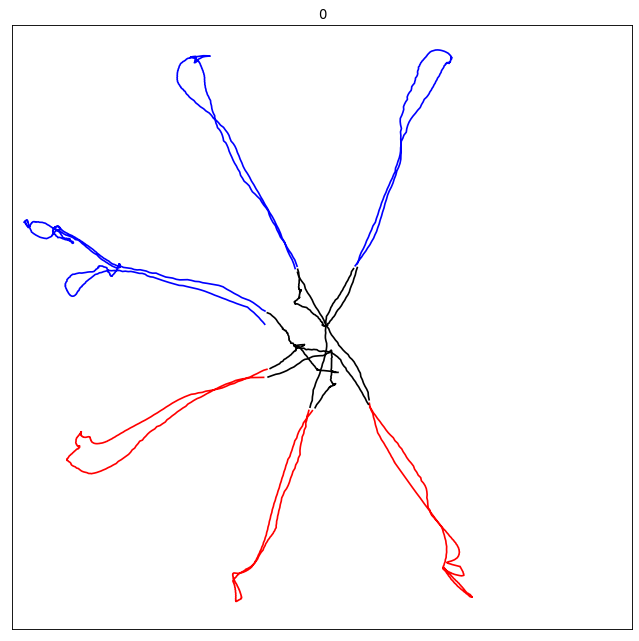

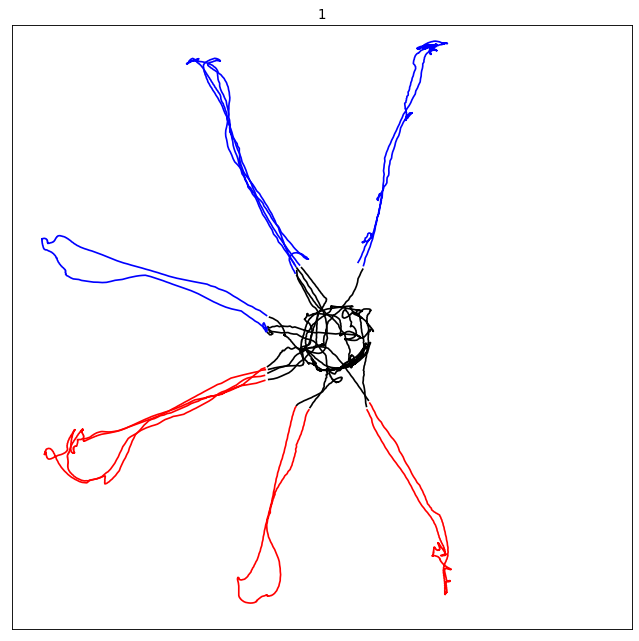

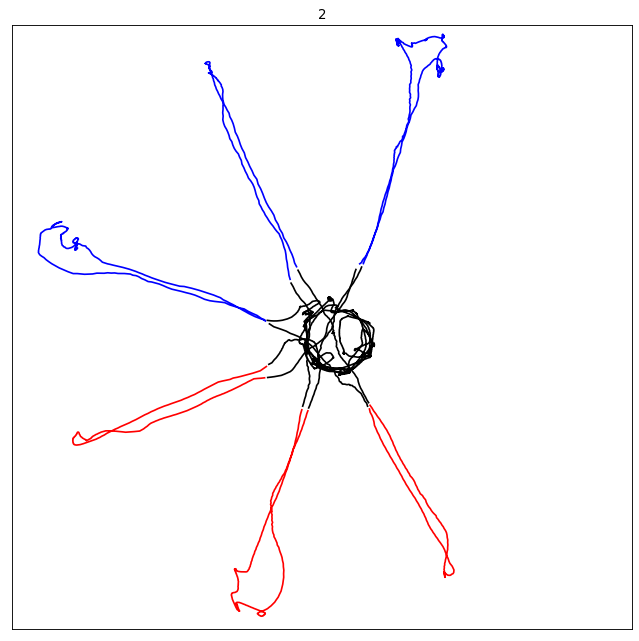

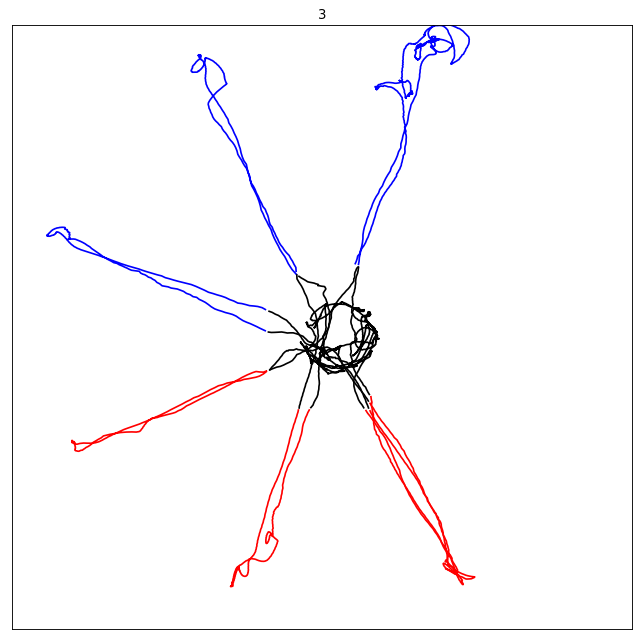

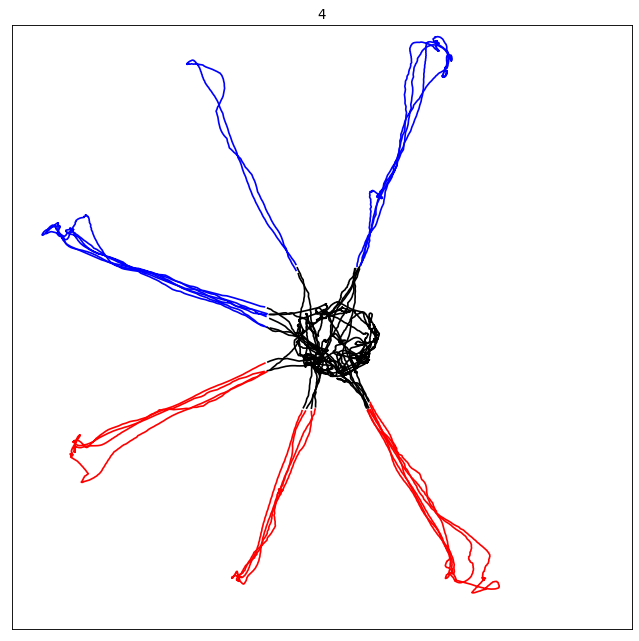

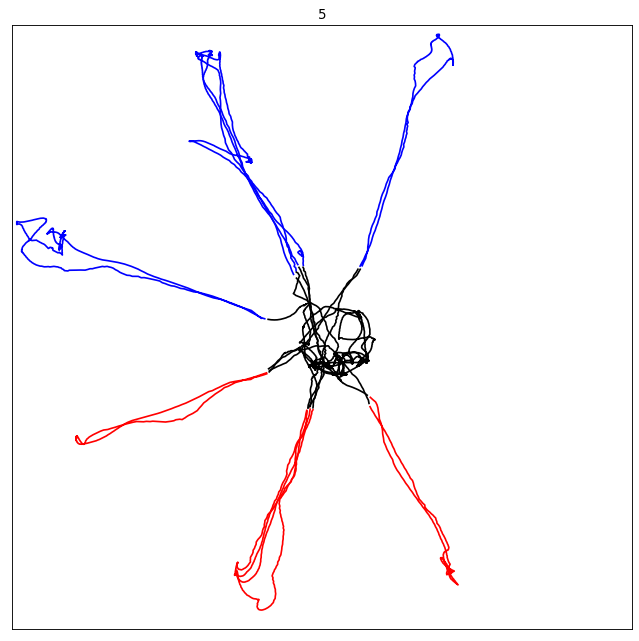

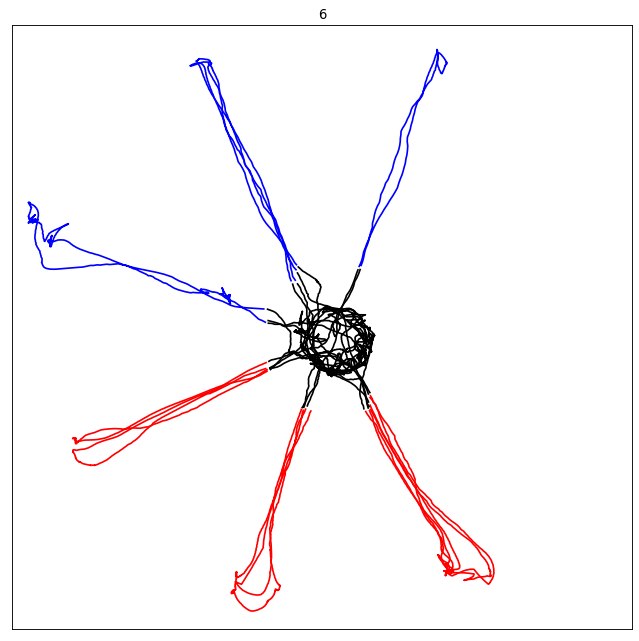

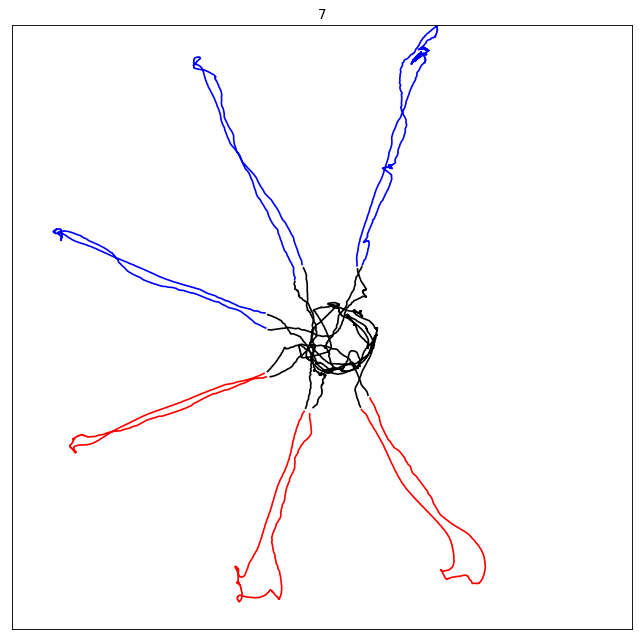

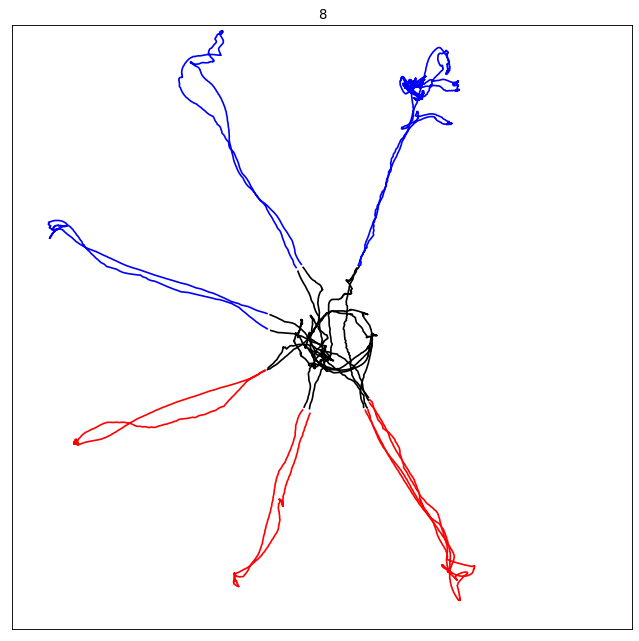

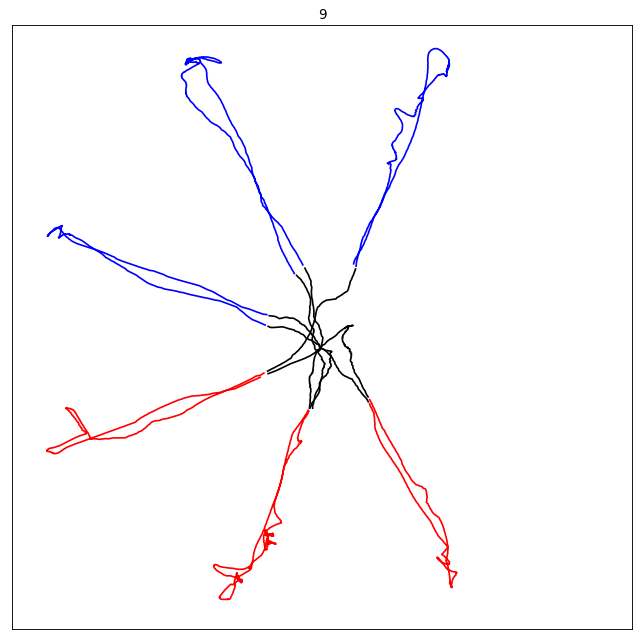

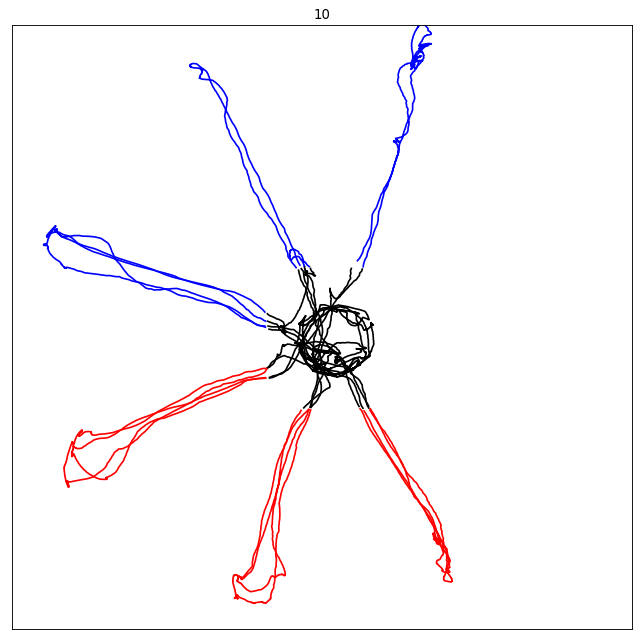

In [477]:
# plot trial by trial
MININ = 150
repruns = []

for ntrial in range(len(trials)):

    #ntrial = 5
    trial = trials[ntrial]
    #plt.plot(whl[trial[0]:trial[1],0], whl[trial[0]:trial[1],1])

    fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

    # plot inh / control arms with different color
    t = trial[0]
    # to plot repeated visits only
    armvis = [False] * 7

    while t  < trial[1]:
        tstart = t
        astart = tarm[t]
        armreach = False
        while t < trial[1] and tarm[t] == astart:
            if tarm[t] < 6 and (whl[t][0]-arm_ends[tarm[t]][0])**2 + (whl[t][1]-arm_ends[tarm[t]][1])**2 < REACHRAD ** 2:
                armreach = True
            t += 1   

        col = 'red' if astart in [3, 5, 4] else ('blue' if astart < 6 else 'black')
        #if armvis[astart] and t-tstart > MININ and armreach or astart==6: # to plot only repeated VISITS (with min len applied)
        plt.plot(whl[tstart:t,0], whl[tstart:t, 1], color=col)
        repruns.append([tstart, t])
            
        if t - tstart > MININ:
            armvis[astart]= True

    plt.xlim([0, 170])
    plt.ylim([0, 170])
    plt.title(str(ntrial))    
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    #plt.subplots_adjust(left=0.13, right=0.955)
    
    plt.savefig('/home/igor/Pictures/19-08-20/6AWM_TRACK_%s_%d_REP.png' % (day, ntrial))


In [172]:
print(tarm)

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


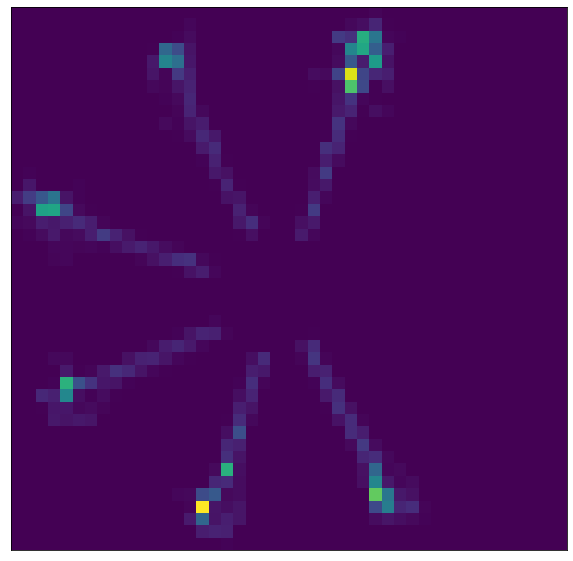

In [479]:
# just occupancy map of the whl - try also speed-filtered !
# TODO ONLY REPEATED TRIALS
BSIZE = 4
# 3-5-8-10-15
# 4 already includes head rotation
MINSPEED = 10
cx = 84
cy = 84
bmax = int(max(np.max(whl[:,0])/BSIZE, np.max(whl[:,1])/BSIZE)) + 1
occ = np.zeros((bmax+1, bmax))
speed = whl_to_speed(whl)
print (occ)
#for w in range(len(whl)):
for reprun in repruns:
    for w in range(reprun[0], reprun[1]):
        # out of center !
        if (whl[w][0] - cx) ** 2 + (whl[w][1] - cy) ** 2 > 400 and speed[w] > MINSPEED:
            occ[int(whl[w][0]/4), int(whl[w][1]/4)] += 1
plt.imshow(occ.transpose(), origin='lower')

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

In [187]:
print(whl)

[[81.252  86.913 ]
 [80.4195 87.0795]
 [81.252  87.0795]
 ...
 [85.0815 83.0835]
 [84.0825 82.917 ]
 [84.582  82.917 ]]
